*Data source:*

- [*FAOSTAT: Food and Agriculture Organization of the United Nations*](https://www.fao.org/faostat/en/#release_calendar)
- [*The world bank*](https://databank.worldbank.org/)
- *https://tradingeconomics.com/country-list/temperature*

**Table of contents**<a id='toc0_'></a>    
1. [Import libraries and other useful code.](#toc1_)    
2. [Dataset reading and preprocessing.](#toc2_)    
    2.1. [Crop dataset](#toc2_1_)    
    2.2. [Precipitations dataset](#toc2_2_)    
        2.2.1. [NaN values](#toc2_2_1_) 
    2.3. [Pesticides dataset](#toc2_3_) 
    2.4. [Fertilizers dataset](#toc2_4_)    
        2.4.1. [NaN values](#toc2_4_1_)
    2.5. [Temperature dataset](#toc2_5_)    
3. [Create final dataframe.](#toc3_)    
    3.1. [Merge datasets](#toc3_1_) 
    3.2. [NaN values](#toc3_2_) 

---
## 1. [Import libraries and other useful code](#toc0_)<a id='toc1_'></a>

In [1]:
import numpy as np 
import pandas as pd
import os
import re
import json

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Set the display of numbers in decimal notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. [Dataset reading and preprocessing](#toc0_)<a id='toc2_'></a>

### 2.1. [Crop dataset](#toc0_)<a id='toc2_1_'></a>

In [45]:
crop = pd.read_csv('Data/crop_yield/Production_Crops_Livestock_E_All_Data_Normalized.csv',encoding='latin-1', low_memory=False) # low_memory = False to avoid Dtypewarning

I have downloaded a dataset that contains information on continents as well as countries. I am going to clean up the Area column so that only the rows with the countries are displayed.

In [7]:
# # Save country list in a JSON file
# with open('json/countries.json', 'w') as f:
#     json.dump(countries, f)

In [46]:
# read JSON file with countries list
with open('json/countries.json', 'r') as f:
    countries = json.load(f)

In [47]:
# Filter the original DataFrame to keep only the countries. 
crop = crop[crop['Area'].isin(countries)]

In [48]:
# correction of country names
crop['Area'].replace('Bolivia (Plurinational State of)','Bolivia', inplace=True)
crop['Area'].replace('Iran (Islamic Republic of)','Iran', inplace=True)
crop['Area'].replace('Micronesia (Federated States of)','Micronesia', inplace=True)
crop['Area'].replace('Netherlands (Kingdom of the)','Netherlands', inplace=True)
crop['Area'].replace('United Kingdom of Great Britain and Northern Ireland','United Kingdom', inplace=True)
crop['Area'].replace('Venezuela (Bolivarian Republic of)','Venezuela', inplace=True)
crop['Area'].replace('United States of America','United States', inplace=True)
crop['Area'].replace("Côte d'Ivoire","Ivory Coast", inplace=True)
crop['Area'].replace('Russian Federation','Russia', inplace=True)
crop['Area'].replace('United Republic of Tanzania','Tanzania', inplace=True)
crop['Area'].replace('Türkiye','Turkey', inplace=True)
crop['Area'].replace('Czechia','Czech Republic', inplace=True)
crop['Area'].replace('Viet Nam','Vietnam', inplace=True)
crop['Area'].replace('Syrian Arab Republic','Syria', inplace=True)
crop['Area'].replace('Congo','Republic of the Congo', inplace=True)

values_to_drop = ['Ethiopia PDR','China, Hong Kong SAR', 'China, Macao SAR', 'China, Taiwan Province of', 'China, mainland','Sudan (former)']
crop = crop[~crop['Area'].isin(values_to_drop)]

In [49]:
crop.shape

(3007620, 14)

In [50]:
# To have the same years in the datasets, filter the datasets from year 2010
crop = crop[crop['Year']>=2010]

In [51]:
# Delete innecessary columns
crop.drop(columns=['Area Code', 'Area Code (M49)','Item Code (CPC)','Element Code','Unit','Year Code','Flag','Note'], inplace=True)

In [52]:
crop['Element'].unique()

array(['Area harvested', 'Yield', 'Production', 'Stocks',
       'Producing Animals/Slaughtered', 'Laying', 'Yield/Carcass Weight',
       'Milk Animals'], dtype=object)

In [53]:
# delete element types
delete_elements = ['Stocks', 'Laying', 'Milk Animals', 'Prod Popultn', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight']

# Filter the DataFrame to exclude the rows with the specified elements, and keep area harvested, yield and production
crop = crop[~crop['Element'].isin(delete_elements)]

In [54]:
# Change the name to Elements type
crop['Element'] = crop['Element'].replace('Area harvested', 'area_harvested_ha')
crop['Element'] = crop['Element'].replace('Yield', 'yield_hg/ha')
crop['Element'] = crop['Element'].replace('Production', 'production_tonnes')

Item column contains primary crops, processed crops, primary livestock, processed livestock and live animals. We are keeping only the primary crops:

In [17]:
# # Save country list in a JSON file
# with open('json/primarycrops.json', 'w') as f:
#     json.dump(primarycrops_list, f)

In [55]:
# read JSON file with primary crops list
with open('json/primarycrops.json', 'r') as f:
    primarycrops_list = json.load(f)

In [56]:
# Filter the DataFrame to keep only the rows with the specified elements
crop = crop[crop['Item'].isin(primarycrops_list)]

In [57]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, Item and Year.

crop = crop.pivot_table(index=['Area', 'Item Code', 'Item', 'Year'], columns='Element', values='Value').reset_index()
# index: The columns we want to keep unchanged in the resulting DataFrame.
# columns: The column whose values will be used to create the new columns in the resulting DataFrame.
# values: The column whose values will be used to populate the resulting DataFrame. 

In [58]:
# Change the name to the Item column
crop.rename(columns={'Item': 'Crop'}, inplace=True)

In [59]:
crop.head()

Element,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,2010,2354000.00,4532000.00,19252.00
1,Afghanistan,15,Wheat,2011,2232000.00,3388000.00,15179.00
2,Afghanistan,15,Wheat,2012,2512000.00,5050000.00,20104.00
3,Afghanistan,15,Wheat,2013,2552922.00,5169235.00,20248.00
4,Afghanistan,15,Wheat,2014,2653746.00,5370259.00,20237.00


### 2.2. [Precipitations dataset](#toc0_)<a id='toc2_2_'></a>

In [90]:
prec = pd.read_csv('Data/TWB_avg_precip/prec_filtered_metadata.csv',encoding='latin-1') # Average precipitation in depth (mm per year)

In [82]:
prec.head()

,Series Name,Series Code,Country Name,Country Code,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,Afghanistan,AFG,327,327,327,327,327,327,327,327,327,327,327,..,..,..
1,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,Albania,ALB,1485,1485,1485,1485,1485,1485,1485,1485,1485,1485,1485,..,..,..
2,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,Algeria,DZA,89,89,89,89,89,89,89,89,89,89,89,..,..,..
3,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,American Samoa,ASM,..,..,..,..,..,..,..,..,..,..,..,..,..,..
4,Average precipitation in depth (mm per year),AG.LND.PRCP.MM,Andorra,AND,..,..,..,..,..,..,..,..,..,..,..,..,..,..


In [91]:
# Delete innecessary columns
prec.drop(columns=['Series Name', 'Series Code','Country Code'], inplace=True)

In [92]:
# Change name columns
col = prec.columns
# Apply the regular expression using comprehension lists
years = [re.search(r'\d{4}', x).group() if re.search(r'\d{4}', x) else 'Area' for x in col]
# Change name columns with the new list years
prec.columns = years

In [93]:
prec.head()

,Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,327,327,327,327,327,327,327,327,327,327,327,..,..,..
1,Albania,1485,1485,1485,1485,1485,1485,1485,1485,1485,1485,1485,..,..,..
2,Algeria,89,89,89,89,89,89,89,89,89,89,89,..,..,..
3,American Samoa,..,..,..,..,..,..,..,..,..,..,..,..,..,..
4,Andorra,..,..,..,..,..,..,..,..,..,..,..,..,..,..


In [94]:
# correction of country names
prec['Area'].replace('Venezuela, RB','Venezuela', inplace=True)
prec['Area'].replace('Iran, Islamic Rep.','Iran', inplace=True)
prec['Area'].replace('Congo, Dem. Rep.','Democratic Republic of the Congo', inplace=True)
prec['Area'].replace('Congo, Rep.','Republic of the Congo', inplace=True)
prec['Area'].replace('Russian Federation','Russia', inplace=True)
prec['Area'].replace('Turkiye','Turkey', inplace=True)
prec['Area'].replace("Cote d'Ivoire","Ivory Coast", inplace=True)
prec['Area'].replace("Egypt, Arab Rep.","Egypt", inplace=True)
prec['Area'].replace('Yemen, Rep.','Yemen', inplace=True)
prec['Area'].replace('Czechia','Czech Republic', inplace=True)
prec['Area'].replace('Viet Nam','Vietnam', inplace=True)
prec['Area'].replace('Syrian Arab Republic','Syria', inplace=True)

In [95]:
prec.tail()

,Area,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,Indicator Name,Source,Topic,Periodicity,Development relevance,Limitations and exceptions,License URL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223,Average precipitation in depth (mm per year),"Food and Agriculture Organization, electronic ...",Environment: Land use,Annual,The agriculture sector is the most water-inten...,The data are collected by the Food and Agricul...,https://datacatalog.worldbank.org/public-licen...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# delete the last two rows
prec = prec.iloc[:-2]

There are a lot of nan in the back rows, this will be addressed in the preprocessing section.

#### 2.2.1. <a id='toc2_2_1_'></a>[NaN values](#toc0_)

In [97]:
# replace .. by NaN
prec.replace('..', np.nan, inplace=True)

<Axes: >

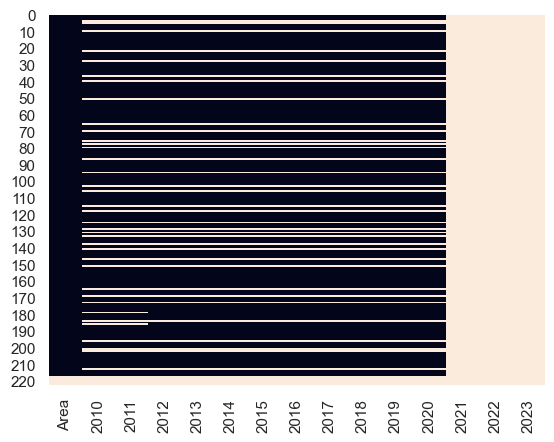

In [98]:
sns.heatmap(prec.isnull(), cbar=False) # Visualize null values with a heatmap

In [99]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area     2.25
2010    18.92
2011    18.92
2012    18.02
2013    18.02
2014    18.02
2015    18.02
2016    18.02
2017    18.02
2018    18.02
2019    18.02
2020    18.02
2021   100.00
2022   100.00
2023   100.00
dtype: float64

In [100]:
# percentage of nan values (rows)
prec.isnull().sum(axis=1) / prec.shape[1] * 100

0      20.00
1      20.00
2      20.00
3      93.33
4      93.33
       ...  
217   100.00
218   100.00
219   100.00
220   100.00
221   100.00
Length: 222, dtype: float64

In [101]:
# # Calculate the percentage of null values in each row
percent_missing_rows = prec.isnull().sum(axis=1) / prec.shape[1] * 100

# Filter out rows with a percentage of nulls = 100
missing_rows = percent_missing_rows[percent_missing_rows==100].index

# Display rows with a percentage of nulls = 100
prec.loc[missing_rows]

# delete missing_rows
prec.drop(missing_rows, inplace=True)

In [102]:
# no information of the columns 2021, 2022, 2023. Delete

prec.drop(columns=['2021', '2022','2023'], inplace=True)

In [103]:
# percentage of nan values (columns)
prec.isnull().sum() / len(prec) * 100

Area    0.00
2010   17.05
2011   17.05
2012   16.13
2013   16.13
2014   16.13
2015   16.13
2016   16.13
2017   16.13
2018   16.13
2019   16.13
2020   16.13
dtype: float64

In [104]:
prec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Area    217 non-null    object
 1   2010    180 non-null    object
 2   2011    180 non-null    object
 3   2012    182 non-null    object
 4   2013    182 non-null    object
 5   2014    182 non-null    object
 6   2015    182 non-null    object
 7   2016    182 non-null    object
 8   2017    182 non-null    object
 9   2018    182 non-null    object
 10  2019    182 non-null    object
 11  2020    182 non-null    object
dtypes: object(12)
memory usage: 20.5+ KB


In [105]:
prec.columns

Index(['Area', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020'],
      dtype='object')

In [106]:
# Change the number columns type to float
year_col = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020']
prec[year_col]= prec[year_col].astype(float)

As the rainfall values are mm per year and they are continuous variables, we will do the imputation with the mean value of mm per year:

In [107]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in prec.columns:
    repair_null(prec, col)

prec.isnull().sum()/len(prec)*100

Area   0.00
2010   0.00
2011   0.00
2012   0.00
2013   0.00
2014   0.00
2015   0.00
2016   0.00
2017   0.00
2018   0.00
2019   0.00
2020   0.00
dtype: float64

In [108]:
# calculation of the average rain fall from 2010-present in a new column

prec['avg_rainfall_mm_year'] = prec[year_col].mean(axis=1).round(2)

In [109]:
# create a new df with Area and average columns
prec_filtered = prec[['Area','avg_rainfall_mm_year']].copy()

In [110]:
prec_filtered['Area'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'British Virgin Islands',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Democratic Republic of the Congo',
       'Republic of the Congo', 'Costa Rica', 'Ivory Coast', 'Croatia',
       'Cuba', 'Curacao', 'Cyprus', 'Czech Republic', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopi

### 2.3. [Pesticides dataset](#toc0_)<a id='toc2_3_'></a>

In [47]:
pest = pd.read_csv('Data/pesticides_use/pesticides_faostat_filtered.csv',encoding='latin-1',low_memory=False)

In [48]:
pest.head()

,ï»¿Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,RP,Pesticides Use,8,Albania,5157,Agricultural Use,1309,Insecticides,2010,2010,t,375.80,E,Estimated value,NaN
1,RP,Pesticides Use,8,Albania,5157,Agricultural Use,1309,Insecticides,2011,2011,t,317.07,E,Estimated value,NaN
2,RP,Pesticides Use,8,Albania,5157,Agricultural Use,1309,Insecticides,2012,2012,t,157.57,E,Estimated value,NaN
3,RP,Pesticides Use,8,Albania,5157,Agricultural Use,1309,Insecticides,2013,2013,t,214.13,E,Estimated value,NaN
4,RP,Pesticides Use,8,Albania,5157,Agricultural Use,1309,Insecticides,2014,2014,t,34.48,E,Estimated value,NaN


In [49]:
# create new filtered df
pest_filtered = pest[['Area','Item','Year','Value']].copy()
# Change the name to the new column
pest_filtered.rename(columns={'Item': 'pesticides_type'}, inplace=True)
pest_filtered.rename(columns={'Value': 'agricultural_use_tonnes'}, inplace=True)

In [50]:
pest_filtered.isnull().sum()

Area                       0
pesticides_type            0
Year                       0
agricultural_use_tonnes    0
dtype: int64

In [51]:
pest_filtered['pesticides_type'].unique()

array(['Insecticides', 'Herbicides', 'Fungicides and Bactericides',
       'Fungicides â\x80\x93 Seed treatments',
       'Insecticides â\x80\x93 Seed Treatments', 'Rodenticides'],
      dtype=object)

In [52]:
# Clean pesticides_type column
pest_filtered['pesticides_type'] = pest_filtered['pesticides_type'].str.replace('â\x80\x93', ':')

I will also correct the countries in this dataset to match the main dataset, as we will be merging the data in the future.

In [53]:
# correction of country names
pest_filtered['Area'].replace('Bolivia (Plurinational State of)','Bolivia', inplace=True)
pest_filtered['Area'].replace('Iran (Islamic Republic of)','Iran', inplace=True)
pest_filtered['Area'].replace('Micronesia (Federated States of)','Micronesia', inplace=True)
pest_filtered['Area'].replace('Netherlands (Kingdom of the)','Netherlands', inplace=True)
pest_filtered['Area'].replace('United Kingdom of Great Britain and Northern Ireland','United Kingdom', inplace=True)
pest_filtered['Area'].replace('Venezuela (Bolivarian Republic of)','Venezuela', inplace=True)
pest_filtered['Area'].replace('United States of America','United States', inplace=True)
pest_filtered['Area'].replace("Côte d'Ivoire","Ivory Coast", inplace=True)
pest_filtered['Area'].replace('Russian Federation','Russia', inplace=True)
pest_filtered['Area'].replace('United Republic of Tanzania','Tanzania', inplace=True)
pest_filtered['Area'].replace('Türkiye','Turkey', inplace=True)
pest_filtered['Area'].replace('Czechia','Czech Republic', inplace=True)
pest_filtered['Area'].replace('Viet Nam','Vietnam', inplace=True)
pest_filtered['Area'].replace('Syrian Arab Republic','Syria', inplace=True)
pest_filtered['Area'].replace('Congo','Republic of the Congo', inplace=True)

In [54]:
# Save pest_filtered in csv:
pest_filtered.to_csv('Data/pest_preprocessed.csv', index=False) # with outliers

### 2.4. [Fertilizers dataset](#toc0_)<a id='toc2_4_'></a>

In [4]:
fert = pd.read_csv('Data/fertilizers/fertilizers_faostat_filtered.csv',encoding='latin-1',low_memory=False)

In [5]:
fert.head()

,ï»¿Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,RFN,Fertilizers by Nutrient,4,Afghanistan,5510,Production,3102,Nutrient nitrogen N (total),2010,2010,t,12022.00,A,Official figure,Official data from questionnaire
1,RFN,Fertilizers by Nutrient,4,Afghanistan,5157,Agricultural Use,3102,Nutrient nitrogen N (total),2010,2010,t,12929.01,I,Imputed value,NaN
2,RFN,Fertilizers by Nutrient,4,Afghanistan,5159,Use per area of cropland,3102,Nutrient nitrogen N (total),2010,2010,kg/ha,1.63,E,Estimated value,NaN
3,RFN,Fertilizers by Nutrient,4,Afghanistan,5510,Production,3102,Nutrient nitrogen N (total),2011,2011,t,17555.00,A,Official figure,Official data from questionnaire
4,RFN,Fertilizers by Nutrient,4,Afghanistan,5157,Agricultural Use,3102,Nutrient nitrogen N (total),2011,2011,t,22970.63,I,Imputed value,NaN


In [6]:
# Change the name to Elements type
fert['Element'] = fert['Element'].replace('Production', 'production_tonnes')
fert['Element'] = fert['Element'].replace('Agricultural Use', 'agricultural_use_tonnes')
fert['Element'] = fert['Element'].replace('Use per area of cropland', 'use_per_area_kg/ha')

In [7]:
# create new filtered df
fert_filtered = fert[['Area','Item','Element','Year','Value']].copy()
# Change the name to the new column
fert_filtered.rename(columns={'Item': 'fertilizer_type'}, inplace=True)

In [8]:
fert_filtered['Element'].value_counts()

Element
agricultural_use_tonnes    7383
use_per_area_kg/ha         7317
production_tonnes          5934
Name: count, dtype: int64

In [9]:
# pivot.table creates a DataFrame where the items are separated into columns according to the type of item, keeping the relationship with the columns Area, fertilizer_type and Year.

fert_filtered = fert_filtered.pivot_table(index=['Area', 'fertilizer_type', 'Year'], columns='Element', values='Value').reset_index()

In [10]:
fert_filtered.head(2)

Element,Area,fertilizer_type,Year,agricultural_use_tonnes,production_tonnes,use_per_area_kg/ha
0,Afghanistan,Nutrient nitrogen N (total),2010,12929.01,12022.00,1.63
1,Afghanistan,Nutrient nitrogen N (total),2011,22970.63,17555.00,2.90


In [11]:
fert_filtered['fertilizer_type'].value_counts()

fertilizer_type
Nutrient nitrogen N (total)        2484
Nutrient potash K2O (total)        2480
Nutrient phosphate P2O5 (total)    2477
Name: count, dtype: int64

#### 2.4.1. <a id='toc2_4_1_'></a>[NaN values](#toc0_)

In [16]:
fert_filtered.isnull().sum()

Element
Area                          0
fertilizer_type               0
Year                          0
agricultural_use_tonnes      58
production_tonnes          1507
use_per_area_kg/ha          124
dtype: int64

In [17]:
fert_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7441 entries, 0 to 7440
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Area                     7441 non-null   object 
 1   fertilizer_type          7441 non-null   object 
 2   Year                     7441 non-null   int64  
 3   agricultural_use_tonnes  7383 non-null   float64
 4   production_tonnes        5934 non-null   float64
 5   use_per_area_kg/ha       7317 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 348.9+ KB


As the **agricultural use, production and use per area** are continuous variables, we will do the imputation with the mean value:

In [18]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in fert_filtered.columns:
    repair_null(fert_filtered, col)

fert_filtered.isnull().sum()/len(fert_filtered)*100

Element
Area                      0.00
fertilizer_type           0.00
Year                      0.00
agricultural_use_tonnes   0.00
production_tonnes         0.00
use_per_area_kg/ha        0.00
dtype: float64

In [19]:
# convert year variable to object type, because it's discrete.
fert_filtered['Year'] = fert_filtered['Year'].astype(object)

In [20]:
fert_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Element,,,,,,,,
agricultural_use_tonnes,7441.00,386841.57,2102366.43,0.00,541.96,12200.82,101233.00,31140359.25
production_tonnes,7441.00,522083.55,2396428.33,0.00,0.00,0.00,522083.55,40541064.15
use_per_area_kg/ha,7441.00,29.86,41.91,0.00,3.13,14.30,38.83,411.76


In [21]:
# the minimun value is 0 in the three variables. Delete these rows
fert_filtered = fert_filtered[~((fert_filtered['agricultural_use_tonnes'] == 0) | (fert_filtered['production_tonnes'] == 0) | (fert_filtered['use_per_area_kg/ha'] == 0))]
fert_filtered.shape

(3278, 6)

In [44]:
# Save fert_filtered in csv:
fert_filtered.to_csv('Data/fert_preprocessed.csv', index=False) # with outliers

### 2.5. [Temperature dataset](#toc0_)<a id='toc2_5_'></a>

In [111]:
# Data: https://tradingeconomics.com/country-list/temperature
temp = {
    'Country': [
        'Burkina Faso', 'Mali', 'Qatar', 'Senegal', 'United Arab Emirates', 'Mauritania', 'Bahrain',
        'Aruba', 'Djibouti', 'Gambia', 'Benin', 'Maldives', 'Guinea-Bissau', 'Cayman Islands',
        'Oman', 'Marshall Islands', 'Kiribati', 'Ghana', 'Singapore', 'Niger', 'Kuwait', 'Sudan',
        'Guam', 'Palau', 'Samoa', 'Togo', 'Micronesia', 'St Kitts and Nevis', 'American Samoa',
        'Chad', 'Cambodia', 'Northern Mariana Islands', 'Sri Lanka', 'Nigeria', 'Seychelles',
        'Somalia', 'Antigua and Barbuda', 'Ivory Coast', 'Virgin Islands', 'St Lucia', 'Thailand',
        'Dominica', 'Sierra Leone', 'Philippines', 'Suriname', 'Eritrea', 'Saudi Arabia',
        'Trinidad and Tobago', 'Barbados', 'Malaysia', 'Grenada', 'Guyana', 'Cuba', 'Bahamas',
        'Jamaica', 'St Vincent and the Grenadines', 'Indonesia', 'Guinea', 'Solomon Islands',
        'Belize', 'Nicaragua', 'Bangladesh', 'Central African Republic', 'Brazil', 'Venezuela',
        'Yemen', 'Liberia', 'Gabon', 'Panama', 'El Salvador', 'Kenya', 'India', 'Tonga',
        'Republic of the Congo', 'Haiti', 'Fiji', 'Cameroon', 'Puerto Rico', 'Equatorial Guinea',
        'Mayotte', 'Papua New Guinea', 'Vanuatu', 'Vietnam', 'Colombia', 'Honduras',
        'Sao Tome and Principe', 'Costa Rica', 'Dominican Republic', 'Mozambique', 'Democratic Republic of the Congo',
        'Algeria', 'French Polynesia', 'Laos', 'Myanmar', 'Paraguay', 'Iraq', 'Guatemala',
        'Comoros', 'Hong Kong', 'Ethiopia', 'Macau', 'New Caledonia', 'Mauritius', 'Egypt',
        'Uganda', 'Tanzania', 'Libya', 'Madagascar', 'Cape Verde', 'Malawi', 'Pakistan',
        'Botswana', 'Australia', 'Zambia', 'Zimbabwe', 'Mexico', 'Angola', 'Tunisia', 'Ecuador',
        'Swaziland', 'Taiwan', 'Bolivia', 'Burundi', 'Malta', 'Namibia', 'Israel', 'Jordan',
        'Palestine', 'Peru', 'Cyprus', 'Iran', 'Syria', 'Rwanda', 'Morocco', 'South Africa',
        'Uruguay', 'Turkmenistan', 'Portugal', 'Lebanon', 'Spain', 'Argentina', 'Monaco',
        'Greece', 'Uzbekistan', 'Afghanistan', 'Nepal', 'Italy', 'San Marino', 'Azerbaijan',
        'Albania', 'Croatia', 'France', 'South Korea', 'Lesotho', 'Hungary', 'Serbia', 'Japan',
        'Bulgaria', 'Turkey', 'Belgium', 'Moldova', 'Netherlands', 'Macedonia', 'New Zealand',
        'Bosnia and Herzegovina', 'Luxembourg', 'Romania', 'Slovenia', 'Montenegro', 'Germany',
        'Bhutan', 'Ireland', 'United Kingdom', 'Ukraine', 'Georgia', 'Isle of Man', 'Slovakia',
        'Denmark', 'Andorra', 'United States', 'Czech Republic', 'Poland', 'Chile', 'Liechtenstein',
        'Austria', 'Armenia', 'China', 'Switzerland', 'Kazakhstan', 'Belarus', 'Lithuania',
        'North Korea', 'Latvia', 'Faroe Islands', 'Estonia', 'Tajikistan', 'Kyrgyzstan', 'Sweden',
        'Finland', 'Norway', 'Iceland', 'Mongolia', 'Russia', 'Canada', 'Greenland'
    ],
    'Last': [
    29.28, 29.19, 29.11, 29.00, 28.93, 28.9, 28.84, 28.82, 28.6, 28.46, 28.09, 28.08, 28.05, 28.01,
    27.94, 27.9, 27.77, 27.73, 27.7, 27.61, 27.58, 27.57, 27.54, 27.54, 27.53, 27.47, 27.45, 27.34,
    27.31, 27.28, 27.25, 27.25, 27.24, 27.15, 27.11, 27.1, 27.06, 26.84, 26.84, 26.83, 26.78, 26.68,
    26.64, 26.61, 26.53, 26.49, 26.46, 26.46, 26.45, 26.35, 26.33, 26.16, 26.14, 26.05, 26.02, 25.98,
    25.96, 25.95, 25.89, 25.83, 25.81, 25.74, 25.56, 25.54, 25.52, 25.51, 25.47, 25.46, 25.33, 25.23,
    25.22, 25.2, 25.1, 25.05, 25.01, 24.98, 24.94, 24.94, 24.89, 24.87, 24.78, 24.76, 24.73, 24.71,
    24.71, 24.66, 24.64, 24.57, 24.42, 24.38, 24.11, 24.05, 24.05, 23.96, 23.86, 23.81, 23.77, 23.74,
    23.62, 23.45, 23.4, 23.37, 23.27, 23.23, 23.14, 22.9, 22.8, 22.7, 22.67, 22.55, 22.23, 22.00,
    21.96, 21.92, 21.83, 21.7, 21.63, 21.44, 21.07, 20.92, 20.79, 20.68, 20.43, 20.26, 20.24, 20.23,
    19.77, 19.7, 19.58, 19.33, 19.3, 19.17, 19.14, 19.1, 18.42, 17.73, 17.66, 16.9, 15.66, 15.3, 15.07,
    15.01, 14.88, 14.86, 14.48, 14.39, 14.38, 14.14, 13.84, 13.31, 13.16, 13.16, 12.76, 12.64, 12.62,
    12.56, 12.42, 12.28, 12.24, 11.98, 11.9, 11.72, 11.66, 11.66, 11.57, 11.43, 11.2, 11.04, 11.00,
    10.83, 10.56, 10.35, 10.11, 10.04, 9.92, 9.89, 9.81, 9.77, 9.73, 9.73, 9.71, 9.7, 9.37, 9.05,
    8.65, 8.64, 8.1, 8.08, 8.06, 7.98, 7.95, 7.46, 7.4, 7.1, 6.9, 5.09, 3.93, 3.84, 3.24, 2.88,
    2.11, 1.31, -2.87, -4.22, -18.62
],
    'Previous': [
    30.01, 29.78, 29.42, 29.62, 29.09, 29.3, 29.18, 29.03, 28.52, 29.03, 28.7, 28.14, 28.68, 27.99,
    28.1, 28.16, 27.89, 28.3, 27.75, 28.09, 27.89, 28.17, 27.88, 27.58, 27.54, 28.04, 27.42, 27.6,
    27.34, 27.7, 27.44, 27.65, 27.4, 27.67, 27.26, 26.93, 27.33, 27.37, 27.11, 27.03, 26.9, 26.9,
    27.19, 26.7, 26.56, 26.88, 26.8, 26.58, 26.63, 26.47, 26.49, 26.15, 26.06, 25.87, 26.07, 26.16,
    26.01, 26.6, 25.89, 26.15, 26.09, 25.7, 25.78, 25.57, 25.61, 25.64, 25.87, 25.66, 25.59, 25.53,
    25.25, 25.09, 25.16, 25.23, 25.15, 25.03, 25.2, 25.17, 25.08, 25.08, 24.79, 24.66, 25.04, 24.97,
    25.03, 24.93, 24.89, 24.75, 24.53, 24.46, 23.92, 24.45, 24.34, 24.11, 24.01, 24.21, 24.08, 23.92,
    24.19, 23.41, 23.96, 23.09, 23.7, 23.88, 23.22, 23.0, 23.05, 22.87, 22.76, 22.8, 22.03, 21.74,
    22.05, 22.11, 21.87, 21.85, 21.74, 21.33, 21.42, 20.52, 21.07, 20.8, 20.51, 20.22, 20.12, 20.86,
    20.36, 20.34, 19.79, 19.87, 19.57, 19.67, 19.21, 18.48, 18.06, 18.06, 17.69, 16.1, 16.2, 14.31,
    15.4, 13.62, 15.09, 14.76, 14.28, 14.29, 13.52, 13.16, 13.9, 12.89, 12.19, 11.58, 13.14, 12.28,
    11.58, 11.7, 12.45, 11.97, 12.61, 10.48, 10.95, 10.41, 11.39, 11.18, 10.7, 9.77, 10.35, 10.0,
    10.25, 9.49, 10.73, 9.94, 9.39, 9.37, 10.05, 9.92, 8.79, 8.96, 8.38, 10.01, 8.5, 8.75, 9.81,
    7.44, 7.41, 8.81, 8.21, 6.39, 7.83, 7.33, 7.28, 7.81, 6.82, 6.7, 6.3, 4.61, 3.36, 3.08, 2.34,
    2.11, 2.43, 2.08, -3.65, -3.7, -17.6
]
}

temp = pd.DataFrame(temp)
temp


,Country,Last,Previous
0,Burkina Faso,29.28,30.01
1,Mali,29.19,29.78
2,Qatar,29.11,29.42
3,Senegal,29.00,29.62
4,United Arab Emirates,28.93,29.09
...,...,...,...
200,Iceland,2.11,2.43
201,Mongolia,1.31,2.08
202,Russia,-2.87,-3.65
203,Canada,-4.22,-3.70


In [112]:
# calculation of the average temperature last & previous in a new column

temp['avg_temp_ºC'] = temp[['Last','Previous']].mean(axis=1).round(2)

# drop Last & previous columns
temp = temp.drop(['Last','Previous'], axis=1)
# Change the name to the new column
temp.rename(columns={'Country': 'Area'}, inplace=True)

In [113]:
temp.head()

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48
2,Qatar,29.26
3,Senegal,29.31
4,United Arab Emirates,29.01


## 3. [Create final dataframe](#toc0_)<a id='toc3_'></a>

### 3.1. [Merge datasets](#toc0_)<a id='toc3_1_'></a>

Merge crop & prec_filtered & temp

In [114]:
crop.shape

(125815, 7)

In [115]:
crop['Area'].nunique()

196

In [1074]:
crop.head(2)

Element,Area,Item Code,Crop,Year,area_harvested_ha,production_tonnes,yield_hg/ha
0,Afghanistan,15,Wheat,2010,2354000.00,4532000.00,19252.00
1,Afghanistan,15,Wheat,2011,2232000.00,3388000.00,15179.00


In [116]:
prec_filtered.shape

(217, 2)

In [117]:
prec_filtered['Area'].nunique()

217

In [1077]:
prec_filtered.head(2)

,Area,avg_rainfall_mm_year
0,Afghanistan,327.00
1,Albania,1485.00


In [1078]:
temp.shape

(205, 2)

In [822]:
temp['Area'].nunique()

205

In [823]:
temp.head(2)

,Area,avg_temp_ºC
0,Burkina Faso,29.65
1,Mali,29.48


There are more countries in the df prec_filtered. Let's merge them and use an inner join so that only rows that have matches in both tables are included in the column you use to join. Rows that do not have matches in both tables will not be included in the resulting DataFrame.

In [118]:
df = crop.merge(prec_filtered, on='Area', how='inner')
df = df.merge(temp, on='Area', how='inner')

In [119]:
df['Area'].nunique()

172

In [120]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Item Code,115044.00,381.82,202.51,15.00,211.00,401.00,534.00,836.00
Year,115044.00,2016.06,3.74,2010.00,2013.00,2016.00,2019.00,2022.00
area_harvested_ha,113634.00,158389.85,1294795.43,0.00,286.00,3000.00,23203.00,46400000.00
production_tonnes,114881.00,1001484.83,11668556.66,0.00,1188.70,16031.00,133981.00,768594154.00
yield_hg/ha,104844.00,121230.81,266471.15,0.00,17619.75,56137.00,141871.25,8755278.00
avg_rainfall_mm_year,115044.00,1095.17,749.51,18.10,565.00,867.00,1577.00,3240.00
avg_temp_ºC,115044.00,18.78,7.65,-3.96,12.12,21.24,25.24,29.65


In [121]:
df.shape

(115044, 9)

### 3.2. [NaN values](#toc0_)<a id='toc3_2_'></a>

In [122]:
df.drop(columns='Item Code', inplace=True)

In [123]:
# convert year variable to object type, because it's discrete.
df['Year'] = df['Year'].astype(object)

In [124]:
df.isnull().sum()

Area                        0
Crop                        0
Year                        0
area_harvested_ha        1410
production_tonnes         163
yield_hg/ha             10200
avg_rainfall_mm_year        0
avg_temp_ºC                 0
dtype: int64

In [125]:
# There are many area harvested and production values at 0. Delete these rows
df = df[(df['area_harvested_ha'] != 0) & (df['production_tonnes'] != 0)]
df.shape

(106082, 8)

As the **area harvested, production and yield** are continuous variables, we will do the imputation with the mean value:

In [126]:
def repair_null(df, col):
    if df[col].dtype == 'int64' or df[col].dtype == 'float64':
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
    return df 

for col in df.columns:
    repair_null(df, col)

df.isnull().sum()/len(prec)*100

Area                   0.00
Crop                   0.00
Year                   0.00
area_harvested_ha      0.00
production_tonnes      0.00
yield_hg/ha            0.00
avg_rainfall_mm_year   0.00
avg_temp_ºC            0.00
dtype: float64

In [127]:
# filter df by 50 more frequent crops
top50_crops = df['Crop'].value_counts().head(50)
top50_crops.index.tolist()
df_filtered = df[df['Crop'].isin(top50_crops.index.tolist())].reset_index(drop=True)

In [128]:
# Save final df in csv:
df_filtered.to_csv('Data/df_preprocessed.csv', index=False) # with outliers